<a href="https://colab.research.google.com/github/shanto-swe029/Machine-Learning-Assignments/blob/main/Lab-Final/Problem-Set-01/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import cv2
import random
import os
import glob
import albumentations as A
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.layers import Conv2D,SeparableConv2D,Input, Flatten, MaxPooling2D, Dense, Dropout , BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
!pip install google-colab
import google.colab.drive as drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.0 MB/s eta 0:00:00


In [2]:
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/ml/Archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/PNEUMONIA/person1381_virus_2375.jpeg  
  inflating: train/PNEUMONIA/person1608_bacteria_4235.jpeg  
  inflating: train/PNEUMONIA/person445_virus_916.jpeg  
  inflating: train/PNEUMONIA/person302_bacteria_1430.jpeg  
  inflating: train/PNEUMONIA/person1188_bacteria_3137.jpeg  
  inflating: train/PNEUMONIA/person353_virus_728.jpeg  
  inflating: train/PNEUMONIA/person348_bacteria_1602.jpeg  
  inflating: train/PNEUMONIA/person1272_bacteria_3232.jpeg  
  inflating: train/PNEUMONIA/person1294_virus_2222.jpeg  
  inflating: train/PNEUMONIA/person3_bacteria_12.jpeg  
  inflating: train/PNEUMONIA/person124_virus_234.jpeg  
  inflating: train/PNEUMONIA/person378_virus_761.jpeg  
  inflating: train/PNEUMONIA/person1478_bacteria_3848.jpeg  
  inflating: train/PNEUMONIA/person1446_bacteria_3740.jpeg  
  inflating: train/PNEUMONIA/person23_bacteria_91.jpeg  
  inflating: train/PNEUMONIA/person294_bacteria_1381.jpeg  
  inflating

Data Generator

In [4]:
#edit-starts
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
#edit-ends

# Load images from the train directory
train_generator = train_datagen.flow_from_directory(
    'train',
    shuffle=True,
    target_size=(224, 224),  # adjust to the input size of your model
    batch_size=32,  # adjust based on your requirements
    class_mode='binary'  # or 'categorical' for multi-class problems
)

Found 5216 images belonging to 2 classes.


In [5]:
# Initialize the ImageDataGenerator for validation and test data (without data augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from the validation directory
val_generator = val_test_datagen.flow_from_directory(
    'val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load images from the test directory
test_generator = val_test_datagen.flow_from_directory(
    'test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Build the cnn model

In [6]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

In [7]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [8]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(224, 224, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [9]:
model =  build_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 56, 56, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 14, 14, 128)       27072     
                                                      

In [10]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

opt = Adam(learning_rate=0.001)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy',
              metrics=METRICS,
              optimizer=opt,
              run_eagerly=True)

In [11]:
batch_size = 32
nb_epochs = 20

Correcting Data imbalance using Class weight
Due to an imbalanced class we shoud compensate defining the class_weight.

In [12]:
class_weight ={0:1.95, 1:0.67}

Train the Model

In [13]:
%%time
# Fit the model
history = model.fit(train_generator,
                    epochs=nb_epochs,
                    steps_per_epoch=5216/ batch_size,
                    validation_data=val_generator,
                    callbacks=[es, chkpt],
                    class_weight=class_weight)

Epoch 1/20


163/163 [==============================] - 138s 745ms/step - loss: 0.4232 - accuracy: 0.7975 - precision: 0.9508 - recall: 0.7672 - val_loss: 1.0518 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/20
163/163 [==============================] - 123s 754ms/step - loss: 0.2687 - accuracy: 0.8915 - precision: 0.9672 - recall: 0.8839 - val_loss: 1.4028 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/20
163/163 [==============================] - 122s 749ms/step - loss: 0.2296 - accuracy: 0.9062 - precision: 0.9690 - recall: 0.9027 - val_loss: 2.4893 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/20
163/163 [==============================] - 123s 750ms/step - loss: 0.1993 - accuracy: 0.9235 - precision: 0.9785 - recall: 0.9172 - val_loss: 2.8428 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/20
163/163 [==============================] - 125s 762ms/step - loss: 0.1955 - accuracy: 0.

Visualizing model performance

Let's plot the model accuracy and loss for the training and the validating set. These plots show the accuracy and loss values for the training.

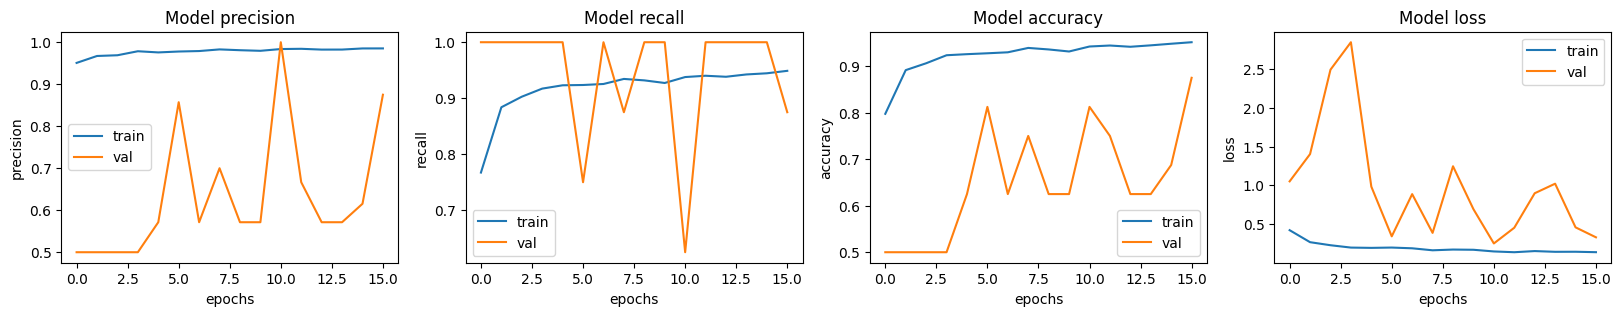

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

Predict and evaluate results

In [15]:
loss, acc, prec, rec = model.evaluate(test_generator)

20/20 [==============================] - 6s 304ms/step - loss: 0.2758 - accuracy: 0.9135 - precision: 0.9286 - recall: 0.9333


Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

pred=model.predict(test_generator)
print(confusion_matrix(test_generator.classes,pred>0.5))

pd.DataFrame(classification_report(test_generator.classes ,pred >0.5,output_dict=True))

20/20 [==============================] - 7s 342ms/step
[[ 86 148]
 [146 244]]


,0,1,accuracy,macro avg,weighted avg
precision,0.370690,0.622449,0.528846,0.496569,0.528039
recall,0.367521,0.625641,0.528846,0.496581,0.528846
f1-score,0.369099,0.624041,0.528846,0.496570,0.528438
support,234.000000,390.000000,0.528846,624.000000,624.000000
